In [ ]:
import os
import pandas as pd
import numpy as np
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark import SparkConf
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir("/media/seconddrive/mta_stationing_problem")

In [ ]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

In [ ]:
fp = os.path.join('data', 'others', 'Manual Check Data.csv')
raw_mcd_df = pd.read_csv(fp)
print("Unique trips: ", raw_mcd_df.TRIP_ID.unique().shape)
print("Duplicates: ", raw_mcd_df[raw_mcd_df.duplicated()].shape)

In [ ]:
raw_mcd_df['TRANSIT_DATE'] = pd.to_datetime(raw_mcd_df['TRANSIT_DATE'], format='%Y%m%d', errors='coerce')
rename = dict(zip(raw_mcd_df.columns, [s.lower() for s in raw_mcd_df.columns]))
raw_mcd_df = raw_mcd_df.rename(rename, axis=1)
display(raw_mcd_df.head(1))
print(raw_mcd_df.shape)
start_date = raw_mcd_df.transit_date.min()
end_date = raw_mcd_df.transit_date.max()

raw_mcd_spark = spark.createDataFrame(raw_mcd_df)

raw_mcd_spark = raw_mcd_spark.withColumn("trip_id",raw_mcd_spark.trip_id.cast('string'))
raw_mcd_spark = raw_mcd_spark.withColumn("block_abbr",raw_mcd_spark.block_abbr.cast('integer'))
raw_mcd_spark = raw_mcd_spark.withColumn("stop_sequence",raw_mcd_spark.stop_sequence.cast('integer'))
raw_mcd_spark = raw_mcd_spark.withColumn("route_id",raw_mcd_spark.route_id.cast('integer'))
raw_mcd_spark = raw_mcd_spark.withColumn("load",raw_mcd_spark.load.cast('double'))
raw_mcd_spark = raw_mcd_spark.withColumn("ons",raw_mcd_spark.ons.cast('double'))
raw_mcd_spark = raw_mcd_spark.withColumn("offs",raw_mcd_spark.offs.cast('double'))
raw_mcd_spark.printSchema()

In [ ]:
f = os.path.join('data', 'apc', 'complete-with-remark-wego-daily.apc.parquet')
apcdata = spark.read.load(f)
apcdata.createOrReplaceTempView("apc")

In [ ]:
# filter subset
query = f"""
SELECT trip_id, 
       transit_date,
       scheduled_time,
       block_abbr,  
       stop_id_original AS stop_id,
       stop_sequence,
       load AS apc_load, 
       offs AS apc_offs, 
       ons AS apc_ons,
       vehicle_id AS apc_vehicle_id,
       route_direction_name, 
       route_id,
       overload_id,
       remark
FROM apc
WHERE (transit_date >= '{start_date.date()}') AND (transit_date <= '{end_date.date()}')
"""
print(query)

apcdata = spark.sql(query)

Loosen merging rule for stop_sequence

In [ ]:
merged_data = raw_mcd_spark.join(apcdata, on=['transit_date', 
                                              'block_abbr',
                                              'stop_id',
                                              'trip_id',
                                              'stop_sequence',
                                              'route_direction_name',
                                              'route_id'])

In [ ]:
# merged_data.count()

In [ ]:
# mcd_df = merged_data.toPandas()
mcd_df = merged_data.toPandas().drop_duplicates(subset=['transit_date', 'block_abbr','stop_id','trip_id','stop_sequence','route_direction_name','route_id'])

In [ ]:
print(mcd_df.shape)
print("Unique trips: ", mcd_df.trip_id.unique().shape)
print(mcd_df[(mcd_df['apc_load'].notnull())].shape)
print("Unique trips: ", mcd_df[(mcd_df['apc_load'].notnull())].trip_id.unique().shape)
print(mcd_df[(mcd_df['apc_ons'].notnull())].shape)
print("Unique trips: ", mcd_df[(mcd_df['apc_ons'].notnull())].trip_id.unique().shape)
print(mcd_df[(mcd_df['remark'].isnull())].shape)
print("Unique trips: ", mcd_df[(mcd_df['remark'].isna())].trip_id.unique().shape)

Finding out which rows are missing/unmatched

In [ ]:
# merged_data = manual_check_data.join(apcdata, on=['transit_date', 
#                                                   'block_abbr',
#                                                   'stop_id',
#                                                   'trip_id',
#                                                   'stop_sequence',
#                                                   'route_direction_name',
#                                                   'route_id'], how='left')
# merged_data = merged_data.toPandas()
# merged_data[merged_data['remark'].isnull()].trip_id.unique().shape
# df = apcdata.toPandas()
# df.query("transit_date == '2021-11-14' and trip_id == '260767' and route_id == 25 and route_direction_name == 'NORTHBOUND'").sort_values('stop_sequence')
# df.head()

I initially filtered out negative and NaN loads, offs and ons. As per discussion I am leaving them in.

In [ ]:
valid_df = mcd_df[mcd_df.load.notnull()]
valid_df.trip_id.unique().shape

In [ ]:
manual_check_data.toPandas().sort_values(by=['transit_date', 'trip_id', 'stop_sequence'])

In [ ]:
invalid_df = mcd_df[mcd_df.load_diff.isnull()]
print(invalid_df.remark.unique())

invalid_df[invalid_df['remark'] != 'clean'].trip_id.unique().shape, invalid_df[invalid_df['remark'] == 'clean'].trip_id.unique().shape

In [ ]:
valid_df.remark.unique()

In [ ]:
mcd_df[f'ons_diff'] = mcd_df['ons'] - mcd_df[f'apc_ons']
ax = mcd_df.ons_diff.plot.kde()
ax.set_xlim(-2, 2)

In [ ]:
_min = range(-20, 1)
_max = range(20, -1, -1)
step = 0.1
thresholds = np.arange(0.0, 1 + step, step)
print(thresholds)
load_range = list(zip(_min, _max))
load_range

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, f1_score
columns = ['initial_load', 'transit_date', 'trip_id', 'route_id', 'stop_id', 'stop_sequence', 'load', 'ons', 'offs', 'apc_load', 'apc_ons', 'apc_offs', 'vehicle_id', 'route_direction_name', 'block_abbr', 'remark']
mcd_df = mcd_df[columns].sort_values(by=['transit_date', 'trip_id', 'stop_sequence'])

with open('manual_check_results.txt', 'a') as the_file:
    the_file.write(f"param,min,max,threshold,precision,recall,f1,f1_score\n")
for param in ['load', 'ons']:
    mcd_df[f'{param}_diff'] = mcd_df[param] - mcd_df[f'apc_{param}']
    for _min, _max in load_range:
        for threshold in [0. , 0.1 ,0.2 ,0.3 ,0.4 ,0.5 ,0.6 ,0.7 ,0.8 ,0.9, 1. ]:
            valid_df = mcd_df[mcd_df.load_diff.notnull()]
            valid_df['good'] = np.where(((valid_df[f'{param}_diff'] >= _min) & (valid_df[f'{param}_diff'] <= _max)), 1, 0)
            valid_df['bad'] = np.where(((valid_df[f'{param}_diff'] >= _min) & (valid_df[f'{param}_diff'] <= _max)), 0, 1)
            grouped_df = valid_df.groupby(['transit_date', 'trip_id']).agg({'initial_load':'first', 
                                                            'route_id':'first', 
                                                            'vehicle_id':'first', 
                                                            'route_direction_name': 'first', 
                                                            'block_abbr':'first', 
                                                            'remark':pd.Series.mode, 
                                                            f'{param}_diff':'count',
                                                            f'{param}_diff':'mean', 
                                                            'bad':'sum', 
                                                            'good':'sum'}).reset_index()
            grouped_df['error_rate'] = grouped_df['bad'] / (grouped_df['good'] + grouped_df['bad'])
            grouped_df['error_flag'] = grouped_df['error_rate'] >= threshold
            grouped_df['pred_error'] = grouped_df['remark'] != 'clean'

            y_true = grouped_df['error_flag']
            y_pred = grouped_df['pred_error']

            p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='binary', beta=1)

            f1score = f1_score(y_true, y_pred)
            
            with open('manual_check_results.txt', 'a') as the_file:
                the_file.write(f"{param},{_min},{_max},{threshold},{p},{r},{f},{f1score}\n")
                print(f"{param},{_min},{_max},{threshold},{p},{r},{f},{f1score}")
    #         break
    #     break
    # break

In [ ]:

results = pd.read_csv('manual_check_results.txt')
results.query("threshold == 0.7")

,param,min,max,threshold,precision,recall,f1,f1_score
0,load,-20,20,0.0,1.000000,0.203506,0.338189,0.338189
1,load,-20,20,0.1,0.215367,0.555556,0.310403,0.310403
2,load,-20,20,0.2,0.213038,0.564815,0.309383,0.309383
3,load,-20,20,0.3,0.208382,0.573718,0.305722,0.305722
4,load,-20,20,0.4,0.207218,0.579805,0.305317,0.305317
...,...,...,...,...,...,...,...,...
457,ons,0,0,0.6,0.013970,0.300000,0.026696,0.026696
458,ons,0,0,0.7,0.013970,0.315789,0.026756,0.026756
459,ons,0,0,0.8,0.013970,0.333333,0.026816,0.026816
460,ons,0,0,0.9,0.013970,0.333333,0.026816,0.026816


Text(0.5, 1.0, 'Load')

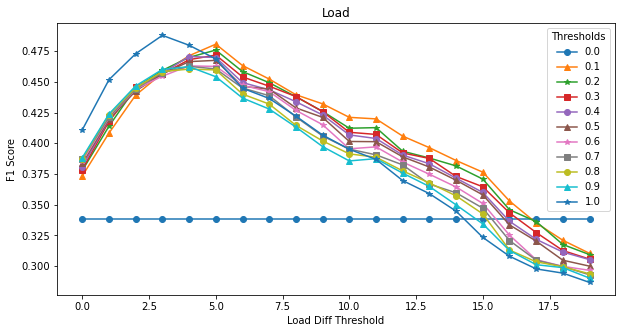

In [95]:
# Plotting
import matplotlib.pyplot as plt

results = pd.read_csv('manual_check_results.txt')
fig, ax = plt.subplots(figsize=(10, 5))
display(results)
param = 'load'
markers = ['o', '^', '*', 's']
for i, t in enumerate([0. , 0.1 ,0.2 ,0.3 ,0.4 ,0.5 ,0.6 ,0.7 ,0.8 ,0.9, 1. ]):
    res_arr = []
    for m in range(1, 21):
        tdf = results.query("max == @m and threshold == @t and param == @param")
        # display(tdf)
        try:
            res_arr.append(tdf.iloc[0]['f1'])
        except:
            print(t, m)
            # display(tdf)
    ax.plot(res_arr, marker=markers[i%4], label=f"{t}")
ax.legend()
ax.get_legend().set_title("Thresholds")
ax.set_xlabel('Load Diff Threshold')
ax.set_ylabel('F1 Score')
ax.set_title('Load')

,param,min,max,threshold,precision,recall,f1,f1_score
0,load,-20,20,0.0,1.000000,0.203506,0.338189,0.338189
1,load,-20,20,0.1,0.215367,0.555556,0.310403,0.310403
2,load,-20,20,0.2,0.213038,0.564815,0.309383,0.309383
3,load,-20,20,0.3,0.208382,0.573718,0.305722,0.305722
4,load,-20,20,0.4,0.207218,0.579805,0.305317,0.305317
...,...,...,...,...,...,...,...,...
457,ons,0,0,0.6,0.013970,0.300000,0.026696,0.026696
458,ons,0,0,0.7,0.013970,0.315789,0.026756,0.026756
459,ons,0,0,0.8,0.013970,0.333333,0.026816,0.026816
460,ons,0,0,0.9,0.013970,0.333333,0.026816,0.026816


Text(0.5, 1.0, 'Ons')

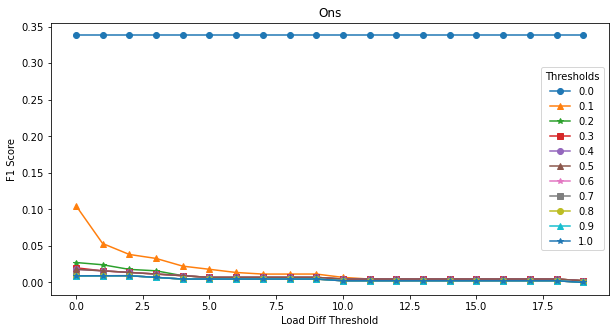

In [96]:
fig, ax = plt.subplots(figsize=(10, 5))
display(results)
param = 'ons'
markers = ['o', '^', '*', 's']
for i, t in enumerate([0. , 0.1 ,0.2 ,0.3 ,0.4 ,0.5 ,0.6 ,0.7 ,0.8 ,0.9, 1. ]):
    res_arr = []
    for m in range(1, 21):
        tdf = results.query("max == @m and threshold == @t and param == @param")
        # display(tdf)
        try:
            res_arr.append(tdf.iloc[0]['f1'])
        except:
            print(t, m)
            # display(tdf)
    ax.plot(res_arr, marker=markers[i%4], label=f"{t}")
ax.legend()
ax.get_legend().set_title("Thresholds")
ax.set_xlabel('Load Diff Threshold')
ax.set_ylabel('F1 Score')
ax.set_title('Ons')

In [94]:
results.query("param == 'load'")

,param,min,max,threshold,precision,recall,f1,f1_score
0,load,-20,20,0.0,1.000000,0.203506,0.338189,0.338189
1,load,-20,20,0.1,0.215367,0.555556,0.310403,0.310403
2,load,-20,20,0.2,0.213038,0.564815,0.309383,0.309383
3,load,-20,20,0.3,0.208382,0.573718,0.305722,0.305722
4,load,-20,20,0.4,0.207218,0.579805,0.305317,0.305317
...,...,...,...,...,...,...,...,...
226,load,0,0,0.6,0.962747,0.215983,0.352816,0.352816
227,load,0,0,0.7,0.960419,0.217621,0.354839,0.354839
228,load,0,0,0.8,0.953434,0.220220,0.357798,0.357798
229,load,0,0,0.9,0.939464,0.221460,0.358428,0.358428


In [92]:
results.query("param == 'ons'")

,param,min,max,threshold,precision,recall,f1,f1_score
231,ons,-20,20,0.0,1.000000,0.203506,0.338189,0.338189
232,ons,-20,20,0.1,0.001164,0.333333,0.002320,0.002320
233,ons,-20,20,0.2,0.001164,1.000000,0.002326,0.002326
234,ons,-20,20,0.3,0.001164,1.000000,0.002326,0.002326
235,ons,-20,20,0.4,0.001164,1.000000,0.002326,0.002326
...,...,...,...,...,...,...,...,...
457,ons,0,0,0.6,0.013970,0.300000,0.026696,0.026696
458,ons,0,0,0.7,0.013970,0.315789,0.026756,0.026756
459,ons,0,0,0.8,0.013970,0.333333,0.026816,0.026816
460,ons,0,0,0.9,0.013970,0.333333,0.026816,0.026816


In [ ]:
import numpy as np

columns = ['initial_load', 'transit_date', 'trip_id', 'route_id', 'stop_id', 'stop_sequence', 'load', 'ons', 'offs', 'apc_load', 'apc_ons', 'apc_offs', 'vehicle_id', 'route_direction_name', 'block_abbr', 'remark']
mcd_df = mcd_df[columns].sort_values(by=['transit_date', 'trip_id', 'stop_sequence'])
# load - apc_load
mcd_df['load_diff'] = mcd_df['load'] - mcd_df['apc_load']

# Threshold: -5, 5
valid_df = mcd_df[mcd_df.load_diff.notnull()]
valid_df['good'] = np.where(((valid_df['load_diff'] >= -5) & (valid_df['load_diff'] <= 5)), True, False)
valid_df['bad'] = np.where(((valid_df['load_diff'] >= -5) & (valid_df['load_diff'] <= 5)), False, True)
valid_df['good'] = valid_df['good'].astype('int')
valid_df['bad'] = valid_df['bad'].astype('int')
grouped_df = valid_df.groupby(['transit_date', 'trip_id']).agg({'initial_load':'first', 
                                                   'route_id':'first', 
                                                   'vehicle_id':'first', 
                                                   'route_direction_name': 'first', 
                                                   'block_abbr':'first', 
                                                   'remark':pd.Series.mode, 
                                                   'load_diff':'count',
                                                   'load_diff':'mean', 
                                                   'bad':'sum', 
                                                   'good':'sum'}).reset_index()

grouped_df['error_rate'] = grouped_df['bad'] / (grouped_df['good'] + grouped_df['bad'])

# % threshold = 30%
grouped_df['error_flag'] = grouped_df['error_rate'] >= 0.30
# grouped_df.error_flag.value_counts().plot(kind='bar')
grouped_df['pred_error'] = grouped_df['remark'] != 'clean'
grouped_df['TP'] = np.where(((grouped_df['error_flag'] == True) & (grouped_df['pred_error'] == True)), 1, 0)
grouped_df['FP'] = np.where(((grouped_df['error_flag'] == False) & (grouped_df['pred_error'] == True)), 1, 0)
grouped_df['FN'] = np.where(((grouped_df['error_flag'] == True) & (grouped_df['pred_error'] == False)), 1, 0)
grouped_df['TN'] = np.where(((grouped_df['error_flag'] == False) & (grouped_df['pred_error'] == False)), 1, 0)
precision = grouped_df['TP'].sum() / (grouped_df['TP'].sum() + grouped_df['FP'].sum())
recall = grouped_df['TP'].sum() / (grouped_df['TP'].sum() + grouped_df['FN'].sum())
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

grouped_df

In [ ]:
grouped_df['TP'].sum(), grouped_df['FP'].sum(), grouped_df['TN'].sum(), grouped_df['FN'].sum(), 

In [ ]:

LOAD_THRESHOLD = (-15, 15)
PERCENT_THRESHOLD = 0.50

# Threshold: -5, 5
valid_df = mcd_df[mcd_df.load_diff.notnull()]
valid_df['good'] = np.where(((valid_df['load_diff'] >= LOAD_THRESHOLD[0]) & (valid_df['load_diff'] <= LOAD_THRESHOLD[1])), 1, 0)
valid_df['bad'] = np.where(((valid_df['load_diff'] >= LOAD_THRESHOLD[0]) & (valid_df['load_diff'] <= LOAD_THRESHOLD[1])), 0, 1)
grouped_df = valid_df.groupby(['transit_date', 'trip_id']).agg({'initial_load':'first', 
                                                   'route_id':'first', 
                                                   'vehicle_id':'first', 
                                                   'route_direction_name': 'first', 
                                                   'block_abbr':'first', 
                                                   'remark':pd.Series.mode, 
                                                   'load_diff':'count',
                                                   'load_diff':'mean', 
                                                   'bad':'sum', 
                                                   'good':'sum'}).reset_index()

grouped_df['error_rate'] = grouped_df['bad'] / (grouped_df['good'] + grouped_df['bad'])

# % threshold = 30%
grouped_df['error_flag'] = grouped_df['error_rate'] >= PERCENT_THRESHOLD
grouped_df['pred_error'] = grouped_df['remark'] != 'clean'

y_true = grouped_df['error_flag']
y_pred = grouped_df['pred_error']

binary = precision_recall_fscore_support(y_true, y_pred, average='binary', beta=1)

f1score = f1_score(y_true, y_pred)
binary, f1score

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
data = mcd_df[mcd_df.load_diff.notnull()].load_diff.to_numpy()                              # Numpy arrays are easier for 1D data
mu, sigma = norm.fit(data)                          # Fit a normal distribution
print("Mu and Std: ", mu, sigma)
CI_95 = norm.interval(0.95, loc=mu, scale=sigma)    # Find the 95% CI endpoints
print("Confidence Interval: ", CI_95)

plt.vlines(CI_95, ymin=0, ymax=0.4)               # plotting stuff
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.show()

In [ ]:
ax = mcd_df.load_diff.plot.kde()
ax.set_xlim(-25, 25)

In [ ]:
mcd_df.describe()

In [ ]:
columns = ['initial_load', 'transit_date', 'trip_id', 'route_id', 'stop_id', 'stop_sequence', 'trip_time', 'load', 'ons', 'offs', 'apc_load', 'apc_ons', 'apc_offs', 'vehicle_id', 'map_latitude', 'map_longitude', 'route_direction_name', 'block_abbr']
mcd_df = mcd_df[columns]
rename = dict(zip(mcd_df.columns, [s.upper() for s in mcd_df.columns]))
mcd_df = mcd_df.rename(rename, axis=1)
mcd_df.head()
mcd_df['TRANSIT_DATE'] = mcd_df['TRANSIT_DATE'].dt.strftime('%Y%m%d')
fp = os.path.join('data', 'others', 'Matched_manual_check_data.csv')
mcd_df.to_csv(fp, index=False)

In [ ]:
# valid_mcd_df = mcd_df.query('apc_load >= 0 and apc_ons >= 0 and apc_offs >= 0')
valid_mcd_df = mcd_df
valid_mcd_df['route_id_direction'] = valid_mcd_df['route_id'].astype('str') + '_' + valid_mcd_df['route_direction_name']
valid_mcd_df.head()

Grouping by `transit_date`, `trip_id` and `route_id_direction` and get `max` `load` of all trips.

In [ ]:
fp = os.path.join('data', 'others', 'manual_check_valids.pkl')
manual_check_trips = valid_mcd_df.groupby(['transit_date', 'trip_id', 'route_id_direction'])\
                                 .agg({"vehicle_id":"first", "load": "max"}).reset_index()
manual_check_trips.to_pickle(fp)
manual_check_trips

In [ ]:
# valid_mcd_df = mcd_df[~mcd_df['apc_load'].isna()]
valid_mcd_df['abs_diff_load'] = valid_mcd_df['load'] - valid_mcd_df['apc_load']
valid_mcd_df['abs_diff_ons'] = valid_mcd_df['ons'] - valid_mcd_df['apc_ons']
valid_mcd_df['abs_diff_offs'] = valid_mcd_df['offs'] - valid_mcd_df['apc_offs']

import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
valid_mcd_df['abs_diff_load'].plot.kde(ax=ax[0])
valid_mcd_df['abs_diff_ons'].plot.kde(ax=ax[1])
valid_mcd_df['abs_diff_offs'].plot.kde(ax=ax[2])

ax[0].set_xlabel('load discrepancy')
ax[1].set_xlabel('ons discrepancy')
ax[2].set_xlabel('offs discrepancy')

ax[1].set_xlim(-2, 2)
ax[2].set_xlim(-3, 3)

# fp = os.path.join('plots', 'manual_check_discrepancies.png')
# plt.savefig(fp, dpi=200, bbox_inches='tight')

## Spot check

In [ ]:
spot_check = mcd_df[(mcd_df['apc_load'].isna())].sample(1).iloc[0]
transit_date = spot_check['transit_date']
stop_id = spot_check['stop_id']
block_abbr = spot_check['block_abbr']
transit_date, stop_id, block_abbr

In [ ]:
mcd_df[(mcd_df['transit_date'] == transit_date) & (mcd_df['apc_load'].isna()) & (mcd_df['stop_id'] == stop_id) & (mcd_df['block_abbr'] == block_abbr)].sort_values(['transit_date', 'vehicle_id'])

There are some entries with negative apcdata load

In [ ]:
df = apcdata.where(F.col("transit_date") == str(transit_date.date())).toPandas()
df[(df['stop_id'] == stop_id) & (df['block_abbr'] == block_abbr)].sort_values(['transit_date', 'apc_vehicle_id'])

## Get apc that we used for trip level model training
* Using `arrival_time` was causing some issues with matching, I used `scheduled_time` instead. This is used for generating time windows.

In [ ]:
processed_triplevel = os.path.join('data', 'processed', 'complete_with_remark_triplevel_df.parquet')
if not os.path.exists(processed_triplevel):
# if True:
       f = os.path.join('data', 'apc', 'complete-with-remark-wego-daily.apc.parquet')
       apcdata = spark.read.load(f)
       apcdata.createOrReplaceTempView("apc")

              # stop_sequence,
       # # filter subset
       query = f"""
       SELECT *
       FROM apc
       WHERE (transit_date >= '{start_date.date()}') AND (transit_date <= '{end_date.date()}')
       """

       apcdata = spark.sql(query)
       apcdata = apcdata.withColumn('day', F.dayofmonth(apcdata.transit_date))
       apcdata = apcdata.withColumn('hour', F.hour(apcdata.scheduled_time))
       apcdata = apcdata.withColumn('dayofweek', F.dayofweek(apcdata.transit_date)) # 1=Sunday, 2=Monday ... 7=Saturday

       filepath = os.path.join("data", "weather", "darksky_nashville_20220406.csv")
       darksky = pd.read_csv(filepath)
       # GMT-5
       darksky['datetime'] = darksky['time'] - 18000
       darksky['datetime'] = pd.to_datetime(darksky['datetime'], infer_datetime_format=True, unit='s')
       darksky = darksky.set_index(darksky['datetime'])
       # darksky = darksky.sort_index().loc[date_range[0]:date_range[1]]
       darksky['year'] = darksky['datetime'].dt.year
       darksky['month'] = darksky['datetime'].dt.month
       darksky['day'] = darksky['datetime'].dt.day
       darksky['hour'] = darksky['datetime'].dt.hour
       val_cols= ['temperature', 'humidity', 'nearest_storm_distance', 'precipitation_intensity', 'precipitation_probability', 'pressure', 'wind_gust', 'wind_speed']
       join_cols = ['year', 'month', 'day', 'hour']
       darksky = darksky[val_cols+join_cols]
       renamed_cols = {k: f"darksky_{k}" for k in val_cols}
       darksky = darksky.rename(columns=renamed_cols)
       darksky = darksky.groupby(['year', 'month', 'day', 'hour']).mean().reset_index()
       darksky=spark.createDataFrame(darksky)
       darksky.createOrReplaceTempView("darksky")

       # join apc and darksky
       apcdata = apcdata.join(darksky,on=['year', 'month', 'day', 'hour'], how='left')
       apcdata.createOrReplaceTempView('apcdata')

       query = """
              SELECT transit_date, trip_id, 
                     first(scheduled_time) as arrival_time,
                     count(stop_id) AS num_records, 
                     first(year) AS year, 
                     first(month) AS month, 
                     first(route_id) AS route_id, 
                     first(route_direction_name) AS route_direction_name, 
                     first(block_abbr) AS block_abbr, 
                     first(dayofweek) as dayofweek, 
                     first(hour) as hour,
                     mean(FLOAT(darksky_temperature)) as temperature,
                     mean(FLOAT(darksky_humidity)) as humidity,
                     mean(FLOAT(darksky_precipitation_intensity)) as precipitation_intensity,
                     mean(FLOAT(sched_hdwy)) AS scheduled_headway,
                     mean(FLOAT(actual_hdwy)) AS actual_headways,
                     percentile(INT(load), 1.00) AS y_reg100
              FROM apcdata
              GROUP BY transit_date, trip_id
              ORDER BY arrival_time
              """

       apcdata_per_trip = spark.sql(query)
       apcdata_per_trip.createOrReplaceTempView('apc_per_trip')
       apcdata_per_trip.cache()

       apcdata_per_trip = apcdata_per_trip.withColumn("route_id_direction", F.concat_ws('_', apcdata_per_trip.route_id, apcdata_per_trip.route_direction_name))

       df = apcdata_per_trip.toPandas()
       # Adding extra features
       # Holidays
       fp = os.path.join('data', 'others', 'US Holiday Dates (2004-2021).csv')
       holidays_df = pd.read_csv(fp)
       holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
       holidays_df['is_holiday'] = True
       df = df.merge(holidays_df[['Date', 'is_holiday']], left_on='transit_date', right_on='Date', how='left')
       df['is_holiday'] = df['is_holiday'].fillna(False)
       df = df.drop(columns=['Date'])

       # School breaks
       fp = os.path.join('data', 'others', 'School Breaks (2019-2022).pkl')
       school_break_df = pd.read_pickle(fp)
       school_break_df['is_school_break'] = True
       df = df.merge(school_break_df[['Date', 'is_school_break']], left_on='transit_date', right_on='Date', how='left')
       df['is_school_break'] = df['is_school_break'].fillna(False)
       df = df.drop(columns=['Date'])

       # Traffic
       fp = os.path.join('data', 'traffic', 'triplevel_speed.pickle')
       speed_df = pd.read_pickle(fp)
       speed_df = speed_df[['transit_date', 'trip_id', 'route_id_direction', 'traffic_speed']]
       df = df.merge(speed_df, how='left', 
                     left_on =['transit_date', 'trip_id', 'route_id_direction'], 
                     right_on=['transit_date', 'trip_id', 'route_id_direction'])
       # df = df[~df['traffic_speed'].isna()]
       df.loc[df['traffic_speed'].isnull(), 'traffic_speed'] = df[df['traffic_speed'].notnull()]['traffic_speed'].mean()

       df.to_parquet(processed_triplevel, engine='auto', compression='gzip')
else:
    df = pd.read_parquet(processed_triplevel, engine='auto')
    df = df.dropna()
    # Removing time_window in case a different one will be used

df = df.reset_index(drop=True)
df.loc[df['y_reg100'] > 100, 'y_reg100'] = 100

## Matching to apcdata for prediction

In [ ]:
df.head()

In [ ]:
fp = os.path.join('data', 'others', 'manual_check_valids.pkl')
valid_mcd_df = pd.read_pickle(fp)
valid_mcd_df = valid_mcd_df[['trip_id', 'transit_date', 'route_id_direction', 'load']]
print(valid_mcd_df.shape)
valid_mcd_df.head()

In [ ]:
from copy import deepcopy

merged_df = pd.merge(df, valid_mcd_df, on=['trip_id', 'transit_date', 'route_id_direction'], how='right').dropna(subset=['arrival_time'])
merged_df

# Setting up prediction and data prep

In [ ]:
import joblib

model012    = joblib.load('models/any_day/XGB_012.joblib')
model234    = joblib.load('models/any_day/XGB_234.joblib')

In [ ]:
def generate_new_features(tdf, time_window=30, past_trips=20, target='y_reg'):
    tdf['day'] = tdf.transit_date.dt.day
    # tdf['time_window'] = tdf.apply(lambda x: get_time_window(x, time_window), axis=1)
    tdf['minute'] = tdf['arrival_time'].dt.minute
    tdf['minuteByWindow'] = tdf['minute'] // time_window
    tdf['temp'] = tdf['minuteByWindow'] + (tdf['hour'] * 60 / time_window)
    tdf['time_window'] = np.floor(tdf['temp']).astype('int')
    tdf = tdf.drop(columns=['minute', 'minuteByWindow', 'temp'])

    sort2 = ['block_abbr', 'transit_date', 'arrival_time', 'route_id_direction']
    tdf = tdf.sort_values(sort2)
    tdf = tdf.dropna()
    return tdf

In [ ]:
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

cat_features = ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break']
ord_features = ['year', 'month', 'hour', 'day']
num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway', 'time_window', 'traffic_speed']

tdf = generate_new_features(merged_df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)
# Group by time windows and get the maximum of the aggregate load/class/sched
# Get mean of temperature (mostly going to be equal)
tdf = tdf.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"year":"first", 
                                                                              "month":"first",
                                                                              "day": "first",
                                                                              "dayofweek":"first", 
                                                                              "hour":"first",
                                                                              "is_holiday": "first",
                                                                              "is_school_break": "first",
                                                                              "temperature":"mean", 
                                                                              "humidity":"mean",
                                                                              "traffic_speed":"mean",
                                                                              "precipitation_intensity": "mean",
                                                                              "scheduled_headway": "max",
                                                                              TARGET: "max"})
tdf = tdf.reset_index(level=[0,1,2])
apc_load = tdf[TARGET]

columns     = joblib.load('models/any_day/TL_X_columns.joblib')
ix_map      = joblib.load('models/any_day/TL_IX_map.joblib')
ohe_encoder = joblib.load('models/any_day/TL_OHE_encoders.joblib')

# OHE for route_id_direction
tdf[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(tdf[cat_features]).toarray()
tdf = tdf.drop(columns=cat_features)

# label encode of categorical variables
for col in ord_features:
    tdf[f'{col}_ix'] = tdf[col].apply(lambda x: ix_map[col][x])
tdf = tdf.drop(columns=ord_features)

tdf = tdf[columns]
tdf = tdf.dropna()
tdf[columns[1:6]] = tdf[columns[1:6]].apply(pd.to_numeric)

In [ ]:
import numpy as np

predictions = model012.predict(tdf)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

tdf['y_pred'] = predictions
## Isolate predictions with bin 2 for 2-3-4
high_bin_df = tdf[tdf['y_pred'] == 2]
high_bin_df = high_bin_df.drop(['y_pred'], axis=1)
high_bin_index = high_bin_df.index
high_bin_df = high_bin_df[columns]

predictions = model234.predict(high_bin_df)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

predictions = predictions + 2
tdf.loc[high_bin_index, 'y_pred'] = predictions
ohe_features = ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break']
tdf[ohe_features] = ohe_encoder.inverse_transform(tdf.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_'))
tdf = tdf[tdf.columns.drop(list(tdf.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_')))]

In [ ]:
input_df = deepcopy(merged_df)
input_df = generate_new_features(input_df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)
# Group by time windows and get the maximum of the aggregate load/class/sched
# Get mean of temperature (mostly going to be equal)
input_df = input_df.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"trip_id":"first",
                                                                                        "year":"first", 
                                                                                        "month":"first",
                                                                                        "day": "first",
                                                                                        "dayofweek":"first", 
                                                                                        "hour":"first",
                                                                                        "is_holiday": "first",
                                                                                        "is_school_break": "first",
                                                                                        "temperature":"mean", 
                                                                                        "humidity":"mean",
                                                                                        "traffic_speed":"mean",
                                                                                        "precipitation_intensity": "mean",
                                                                                        "scheduled_headway": "max",
                                                                                        TARGET: "max"})
input_df = input_df.reset_index(level=[0,1,2])
input_df['y_pred'] = tdf['y_pred']
input_df

In [ ]:
fp = os.path.join('data', 'others', 'manual_check_valids.pkl')
valid_mcd_df = pd.read_pickle(fp)
valid_mcd_df = valid_mcd_df[['trip_id', 'transit_date', 'route_id_direction', 'load']]
valid_mcd_df = pd.merge(valid_mcd_df, input_df[['trip_id', 'transit_date', 'route_id_direction', 'y_pred', 'y_reg100']], how='right')
# load = valid_mcd_df.sort_values('load')['load'].plot()
valid_mcd_df

In [ ]:
labels = [(0, 9), (10, 16), (17, 55), (56, 75), (76, 100)]
percentiles = [(-1, 9), (9, 16), (16, 55), (55, 75), (75, 100)]
bins = pd.IntervalIndex.from_tuples(percentiles)
mycut = pd.cut(valid_mcd_df['load'].tolist(), bins=bins)
valid_mcd_df['y_class'] = mycut.codes

mycut = pd.cut(valid_mcd_df['y_reg100'].tolist(), bins=bins)
valid_mcd_df['y_apc_class'] = mycut.codes

valid_mcd_df.sort_values('load')

In [ ]:
from turtle import color
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
cm = confusion_matrix(valid_mcd_df['y_class'].tolist(), valid_mcd_df['y_pred'].tolist(), labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot(xticks_rotation=0, ax=ax[0], colorbar=False)
ax[0].set_title('Prediction compared to manual check')

cm = confusion_matrix(valid_mcd_df['y_apc_class'].tolist(), valid_mcd_df['y_pred'].tolist(), labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot(xticks_rotation=0, ax=ax[1], colorbar=False)
ax[1].set_title('Prediction compared to apc data')
fp = os.path.join('plots', 'manual_check_comparison.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

Some apc loads are less than 0

In [ ]:
valid_mcd_df.query('y_reg100 < 0')

In [ ]:
valid_mcd_df['y_reg100'].value_counts().sort_index()

In [ ]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True, sharey=True)

valid_mcd_df['load'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
valid_mcd_df.query('y_reg100 >= 0')['y_reg100'].value_counts().sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_title('Manual check load distribution')
# ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
loc = ticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
ax[0].xaxis.set_major_locator(loc)
ax[0].set_ylabel('count')

ax[1].set_title('APC load distribution')
# ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
loc = ticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
ax[1].xaxis.set_major_locator(loc)
ax[1].set_ylabel('count')
ax[1].set_xlabel('load')
plt.xticks(rotation=0)
fp = os.path.join('plots', 'manual vs apc load data.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
with pd.option_context('display.max_rows', 10):
    display(valid_mcd_df.query('y_class == 0 and y_pred == 2'))